In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import torch.nn.functional as F

In [2]:
class UNET(nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        
        # Input channels: 8, 4 met vars at T, 4 at T+6
        self.input_channels = 8
        self.output_channels = 1

        # Pooling function
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Encoder (Contracting Path)
        self.enc1 = self._double_conv(self.input_channels, 64) 
        self.enc2 = self._double_conv(64, 128) 
        self.enc3 = self._double_conv(128, 256) 
        self.enc4 = self._double_conv(256, 512)  
        
        # Decoder (Expansive Path)
        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # 
        self.dec4 = self._double_conv(512, 256) 

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # 
        self.dec3 = self._double_conv(256, 128)  # 128*2 because of skip connection
        
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # 264 x 232
        self.dec2 = self._double_conv(128, 64)  # 64*2 because of skip connection
        
        # Final layer
        self.final = nn.Sequential(
            nn.Conv2d(64, self.output_channels, kernel_size=1),
        )
        
    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
    def forward(self, x):
        # Calls the various steps defined in init

        # Encoder
        enc1 = self.enc1(x)
        enc1_pool = self.pool(enc1)
        
        enc2 = self.enc2(enc1_pool)
        enc2_pool = self.pool(enc2)
        
        enc3 = self.enc3(enc2_pool)
        enc3_pool = self.pool(enc3)

        enc4 = self.enc4(enc3_pool) # Don't apply pool to final encoding step
    
        # Decoder with skip connections
        up4 = self.up4(enc4) 
        up4 = torch.cat((up4, enc3), dim=1)  # Skip connection
        dec4 = self.dec4(up4) 

        up3 = self.up3(dec4)
        up3 = torch.cat((up3, enc2), dim=1)  # Skip connection
        dec3 = self.dec3(up3)
        
        up2 = self.up2(dec3)
        up2 = torch.cat((up2, enc1), dim=1)  # Skip connection
        dec2 = self.dec2(up2)
        
        # Final output
        output = self.final(dec2)
        
        return output

In [3]:
# Load state_dict 
model = UNET()  # Recreate model architecture
model.load_state_dict(torch.load('models/unet_accumulated_t6_minus40.pth', map_location=torch.device('cpu')))
model.eval()  # set evaluation mode

/tmp/ipykernel_2383518/528067792.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/unet_accumulated_t6_minus40.pth', map_location=

UNET(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc1): Sequential(
    (0): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(256, eps=1e-05, momentu

In [4]:
pred_data = np.load('scaled_combined_t6_data_accumulated.npz')['pred_vars'][-40:, 1:, :, :]
targ_data = np.load('scaled_combined_t6_data_accumulated.npz')['target_vars'][-40:]

In [5]:
sample_index = 20

# Get truth
truth_conc = targ_data[sample_index]

# Generate prediction from model
input_stack = pred_data[sample_index]
# print(input_stack.shape)
# Convert to tensor (add batch dimension)
input_tensor = torch.from_numpy(input_stack[np.newaxis, ...]).float()

# Make prediction
with torch.no_grad():
    output_tensor = model(input_tensor)

# Get prediction and store in pre-allocated array
pred_conc = output_tensor.numpy().squeeze()

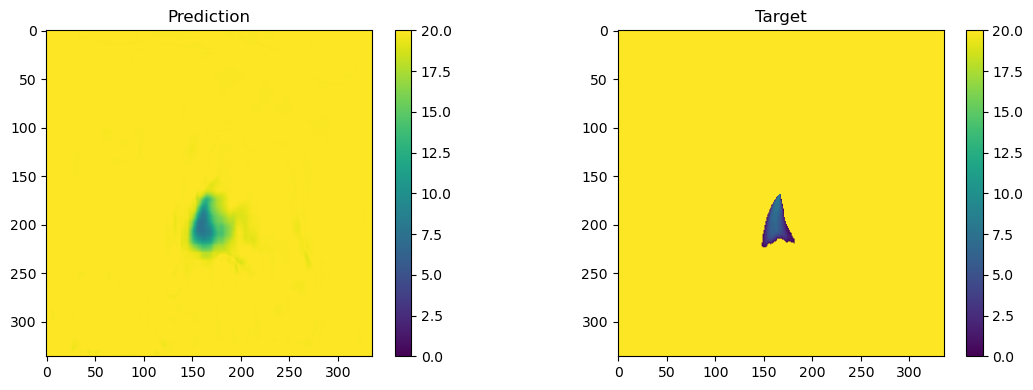

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot prediction with colorbar
im1 = axs[0].imshow(pred_conc, cmap='viridis', vmin=0, vmax=20)
axs[0].set_title("Prediction")
fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)

# Plot target with colorbar
im2 = axs[1].imshow(truth_conc, cmap='viridis', vmin=0, vmax=20)
axs[1].set_title("Target")
fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [7]:
import sys

# Specify the path to the directory containing the .py file
path_to_module = '/lustre/storeB/users/chbou7748/snap_tools/'
sys.path.append(path_to_module)

# Now you can import your module
import snap_map  # replace 'your_module' with the name of your .py file without the .py extension

In [8]:
# Use SNAP file as template for plotting
snap_file_path = f'output_files_t6/ringhals_20230101_00Z.nc'
snap_data = xr.open_dataset(snap_file_path, engine="netcdf4")
snap_data = snap_data.isel(x=slice(188, 524), y=slice(97, 433)) # Dimensions: 336x336

In [9]:
# Add new dimension with np.newaxis
pred_conc_plot = pred_conc[np.newaxis, :, :] 

# Repeat along the new dimension
pred_conc_plot = np.repeat(pred_conc_plot, repeats=13, axis=0)  # Repeat 4 timespred_conc

snap_data['PMCH_acc_concentration'] = xr.DataArray(pred_conc_plot, dims=('time', 'x', 'y'))

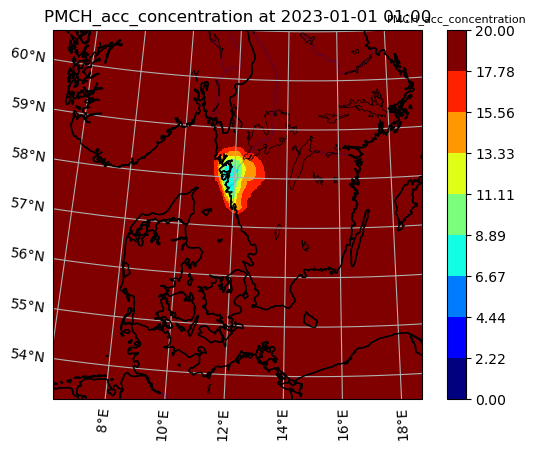

In [10]:
snap_map.plot_var(snap_data, var='PMCH_acc_concentration', scale='linear', tstep=0, maxval=20, minval=0)